# DNN Classification

In [1]:
# preamble
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from labm8 import fs
from labm8 import viz

import clgen
from clgen.atomizer import CharacterAtomizer

from keras.models import Sequential
from keras.layers import Embedding, Merge, LSTM, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [2]:
seed = 7
np.random.seed(seed)

Methods for wrangling data:

In [22]:
def get_features(D):
    return np.array([
        D["comp"].values,
        D["rational"].values,
        D["mem"].values,
        D["localmem"].values,
        D["coalesced"].values,
        D["transfer"].values,
        D["wgsize"].values,
        (D["transfer"].values / (D["comp"].values + D["mem"].values)),  # F1
        (D["coalesced"].values / D["mem"].values),  # F2
        ((D["localmem"].values / D["mem"].values) * D["wgsize"].values),  # F3
        (D["comp"].values / D["mem"].values),  # F4
    ]).T


def get_sequences(D, maxlen):
    for row in D["seq"].values:
        assert(len(row) == maxlen)
    data = np.array(D["seq"].values)
    data.resize((len(D), maxlen))
    return data


def get_labels(D):
    """ cpu/gpu to int """
    encoder = LabelEncoder()
    encoder.fit(D["oracle"].values)
    return encoder.transform(D["oracle"].values)


def get_train_validation_test_splits(D, split=(.6, .2, .2), seed=1):
    """ split dataframe into 3 frames for training, validation, and testing """
    assert(sum(split) == 1.0)
    train_split, validation_split, test_split = split
    
    np.random.seed(seed)
    train_msk = np.random.rand(len(D)) < train_split
    
    train = D[train_msk]
    other = D[~train_msk]
    
    test_msk = np.random.rand(len(other)) < split[2] / sum(split[1:])
    test = other[test_msk]
    validation = other[~test_msk]
 
    np.random.seed()  # re-seed RNG
    return train, validation, test

Load dataset:

In [23]:
dataframe = pd.read_csv(fs.path("~/docs/paper-synthesizing-benchmarks/data/nvidia-clgen.csv"))
dataframe

,benchmark,dataset,comp,rational,mem,localmem,coalesced,atomic,transfer,wgsize,...,speedup,penalty,runtime_cpu,ci_cpu,ci_mean_cpu,runtime_gpu,ci_gpu,ci_mean_gpu,kernel_nlines,kernel_size
0,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,1024,2,2,6,0,5,0,24576,256,...,3.47,0.29,0.059825,0.027666,0.462449,0.017248,0.003733,0.216431,8,191
1,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,1048576,2,2,6,0,5,0,25165824,256,...,2.85,0.35,3.144270,0.301743,0.095966,8.950547,0.010129,0.001132,8,191
2,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,128,2,2,6,0,5,0,3072,128,...,1.43,0.70,0.011245,0.007497,0.666696,0.016096,0.003792,0.235586,8,191
3,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,131072,2,2,6,0,5,0,3145728,256,...,3.14,0.32,0.339146,0.098638,0.290842,1.063418,0.000886,0.000833,8,191
4,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,16384,2,2,6,0,5,0,393216,256,...,1.08,0.92,0.103308,0.002366,0.022902,0.111744,0.003750,0.033559,8,191
5,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,2048,2,2,6,0,5,0,49152,256,...,3.77,0.27,0.072523,0.039571,0.545634,0.019219,0.004765,0.247932,8,191
6,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,2097152,2,2,6,0,5,0,50331648,256,...,3.25,0.31,5.682239,1.689249,0.297286,18.494624,0.106484,0.005758,8,191
7,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,256,2,2,6,0,5,0,6144,256,...,1.08,0.93,0.014862,0.017560,1.181537,0.016051,0.004134,0.257554,8,191
8,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,262144,2,2,6,0,5,0,6291456,256,...,2.95,0.34,0.713604,0.287843,0.403365,2.103014,0.000733,0.000349,8,191
9,005ef03ac277e7418bb806ad623f5066de5031da.cl-A,4096,2,2,6,0,5,0,98304,256,...,2.28,0.44,0.049713,0.021731,0.437129,0.021805,0.004151,0.190369,8,191


Load source code for kernels:

In [24]:
source_dir = fs.path("~/docs/paper-synthesizing-benchmarks/data/clgen-1000/kernels")

srcs = []

for row in dataframe["benchmark"].values:
    filename = re.sub("-[A-Z]$", "", row)
    with open(fs.path(source_dir, filename)) as infile:
        src = infile.read()
    srcs.append(src)
    
dataframe["src"] = srcs

Encode and pad sequences:

In [27]:
atomizer = CharacterAtomizer.from_text(''.join(dataframe["src"].values))

seqs = [atomizer.atomize(seq) for seq in dataframe["src"].values]
seq_length = max(len(s) for s in seqs)
pad_val = atomizer.vocab_size + 1
dataframe["seq"] = list(pad_sequences(seqs, maxlen=seq_length, value=pad_val))
print("vocab size", atomizer.vocab_size)
print("pad val", pad_val)
print("seq length", maxlen)

vocab size 68
pad val 69
seq length 658


Features and labels for training:

In [29]:
train, validation, test = get_train_validation_test_splits(dataframe)

x_train_a = get_features(train)
x_train_b = get_sequences(train, seq_length)
y_train = get_labels(train)

x_val_a = get_features(validation)
x_val_b = get_sequences(validation, seq_length)
y_val = get_labels(validation)

x_test_a = get_features(test)
x_test_b = get_sequences(test, seq_length)
y_test = get_labels(test)

num_features = len(x_train_a[0])
num_classes = len(set(y_train))
vocab_size = atomizer.vocab_size + 1  # +1 for pad value
seq_length = len(x_train_b[0])

print("Num features", num_features)
print("Num tokens", vocab_size)
print("Seq length", seq_length)
print("Num classes", num_classes)
print("Num instances", len(dataframe))

Num features 11
Num tokens 69
Seq length 658
Num classes 2
Num instances 15919


## Dataset exploration

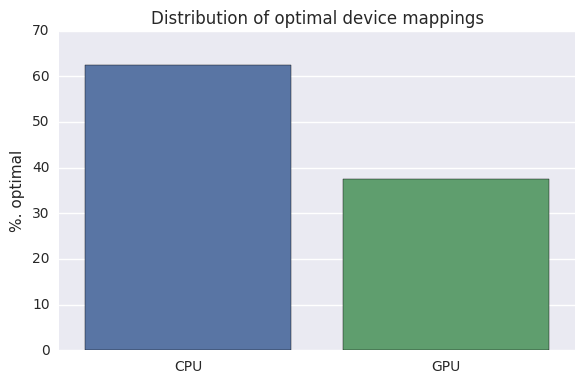

In [30]:
CPU = sum(1 if x == "CPU" else 0 for x in dataframe["oracle"].values)
GPU = sum(1 if x == "GPU" else 0 for x in dataframe["oracle"].values)

assert(CPU + GPU == len(dataframe))

ax = sns.barplot([0, 1], [(CPU / len(dataframe)) * 100, (GPU / len(dataframe)) * 100])
plt.title("Distribution of optimal device mappings")
plt.xticks([0, 1], ["CPU", "GPU"])
plt.xlabel("")
plt.ylabel("%. optimal")
viz.finalise(figsize=(6, 4))

## Source + dynamic props classification

In [31]:
# def create_baseline():
#     model = Sequential()
#     model.add(Dense(num_features, input_dim=num_features, init='normal', activation='relu'))
#     model.add(Dense(1, init='normal', activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

In [32]:
# def evaluate(build_fn, nb_epoch=10):
#     np.random.seed(seed)
#     estimator = KerasClassifier(build_fn=create_baseline, nb_epoch=10, verbose=0)
#     kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
#     return cross_val_score(estimator, X, Y, cv=kfold)

# results = evaluate(create_baseline)
# print("Results: {mean:.2%} (stdev: {std:.2%})".format(mean=results.mean(), std=results.std()))

In [33]:
# def evaluate_standardised(build_fn, nb_epoch=10):
#     np.random.seed(seed)
#     estimators = [
#         ('standardize', StandardScaler()),
#         ('mlp', KerasClassifier(build_fn=build_fn, nb_epoch=nb_epoch, verbose=0))
#     ]
#     pipeline = Pipeline(estimators)
#     kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
#     return cross_val_score(pipeline, X, Y, cv=kfold)

# results = evaluate_standardised(create_baseline)
# print("Results: {mean:.2%} (stdev: {std:.2%})".format(mean=results.mean(), std=results.std()))

In [34]:
# def create_smaller():
#     model = Sequential()
#     model.add(Dense(num_features // 2, input_dim=num_features, init='normal', activation='relu'))
#     model.add(Dense(1, init='normal', activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

In [35]:
# results = evaluate_standardised(create_smaller)
# print("Results: {mean:.2%} (stdev: {std:.2%})".format(mean=results.mean(), std=results.std()))

In [36]:
# def create_larger():
#     model = Sequential()
#     model.add(Dense(num_features, input_dim=num_features, init='normal', activation='relu'))
#     model.add(Dense(num_features // 2, init='normal', activation='relu'))
#     model.add(Dense(1, init='normal', activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

In [37]:
# results = evaluate_standardised(create_larger)
# print("Results: {mean:.2%} (stdev: {std:.2%})".format(mean=results.mean(), std=results.std()))

**Model:**

In [41]:
left = Sequential()
left.add(Dense(num_features, input_dim=num_features, activation="sigmoid"))

embedding_vector_length = 32

right = Sequential()
right.add(Embedding(vocab_size, embedding_vector_length, input_length=seq_length))
right.add(LSTM(100, input_dim=embedding_vector_length, input_length=seq_length))
# right.add(LSTM(32, input_dim=vocab_size, input_length=seq_length))


model = Sequential()
model.add(Merge([left, right], mode='concat'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_7 (Dense)                  (None, 11)            132                                          
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 658, 32)       2208                                         
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 100)           53200                                        
____________________________________________________________________________________________________
dense_8 (Dense)                  (None, 32)            3584        merge_3[0][0]                    
___________________________________________________________________________________________

Generate phony data and train:

In [39]:
np.random.seed(seed)

# generate dummy training data
# x_train_a = np.random.random((1000, num_features))
# x_train_b = np.random.random((1000, seq_length))
# y_train = np.random.random((1000, 1))

# generate dummy validation data
# x_val_a = np.random.random((100, num_features))
# x_val_b = np.random.random((100, seq_length))
# y_val = np.random.random((100, 1))

model.fit([x_train_a, x_train_b], y_train,
           batch_size=64, nb_epoch=5,
           validation_data=([x_val_a, x_val_b], y_val),
           verbose=1)

Train on 9559 samples, validate on 3234 samples
Epoch 1/5


ValueError: setting an array element with a sequence.